In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import joblib

In [2]:
# Cargar los datos desde el archivo CSV en Github
url = "https://raw.githubusercontent.com/JoaZ94/Amazon-Review-Sentiment-Classification/main/amazon_reviews.csv"
data = pd.read_csv(url)

In [3]:
# EDA (Exploratory Data Analysis)
# Revisar las primeras filas del dataset
display(data.head(5))

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


In [4]:
# Obtener información general sobre el dataset
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


None

In [5]:
# Obtener estadísticas descriptivas del dataset
display(data.describe())

,Unnamed: 0,overall,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
count,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000,4915.000000
mean,2457.000000,4.587589,437.367040,1.311089,0.210376,1.521465,1.100712,0.075468,0.020053
std,1418.982617,0.996845,209.439871,41.619161,4.023296,44.123095,39.367949,0.256062,0.077187
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-130.000000,0.000000,0.000000
25%,1228.500000,5.000000,281.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2457.000000,5.000000,431.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3685.500000,5.000000,601.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4914.000000,5.000000,1064.000000,1952.000000,183.000000,2020.000000,1884.000000,1.000000,0.957544


In [6]:
valores_unicos = data['overall'].unique()
print(valores_unicos)

[4. 5. 3. 1. 2.]


In [7]:
# Contar la frecuencia de cada valor único en la columna 'overall'
value_counts = data['overall'].value_counts().sort_index()
value_counts

,count
overall,
1.0,244
2.0,80
3.0,142
4.0,527
5.0,3922


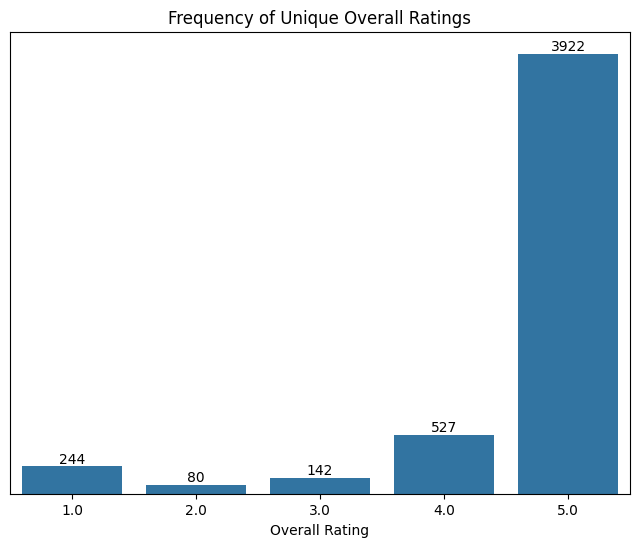

In [8]:
# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=value_counts.index, y=value_counts.values)

# Agregar etiquetas con la frecuencia en cada barra
for index, value in enumerate(value_counts.values):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

# Configurar el gráfico
plt.xlabel('Overall Rating')
plt.ylabel('')  # Dejar el eje Y vacío para que no se muestre la etiqueta
plt.title('Frequency of Unique Overall Ratings')
plt.gca().axes.yaxis.set_visible(False)  # Ocultar el eje Y
plt.show()

In [9]:
# Verificar valores nulos
print(data.isnull().sum())

Unnamed: 0              0
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64


In [10]:
# Eliminar registros con valores nulos o vacíos en la columna 'reviewText'
data = data.dropna(subset=['reviewText'])  # Elimina filas con NaN en 'reviewText'
data = data[data['reviewText'].str.strip() != '']  # Elimina filas con 'reviewText' vacío

In [11]:
# Verificar que no queden registros vacíos
print(data['reviewText'].isnull().sum())  # Debería ser 0
print(data['reviewText'].str.strip().eq('').sum())  # Debería ser 0

0
0


In [12]:
# Clasificar las calificaciones en tres categorías: 0 (Negativo), 1 (Neutral), 2 (Positivo)
def categorize_rating(rating):
    if rating <= 2:
        return 0  # Negativo
    elif rating == 3:
        return 1  # Neutral
    else:
        return 2  # Positivo

In [13]:
# Convertir las etiquetas (calificación) a valores binarios (positivo/negativo)
data['sentiment'] = data['overall'].apply(categorize_rating)
#X = padded_sequences
#y = data['sentiment'].values

In [14]:
# Contar la frecuencia de cada valor único en la columna 'overall'
sentiment_counts = data['sentiment'].value_counts().sort_index()
sentiment_counts

,count
sentiment,
0,324
1,142
2,4448


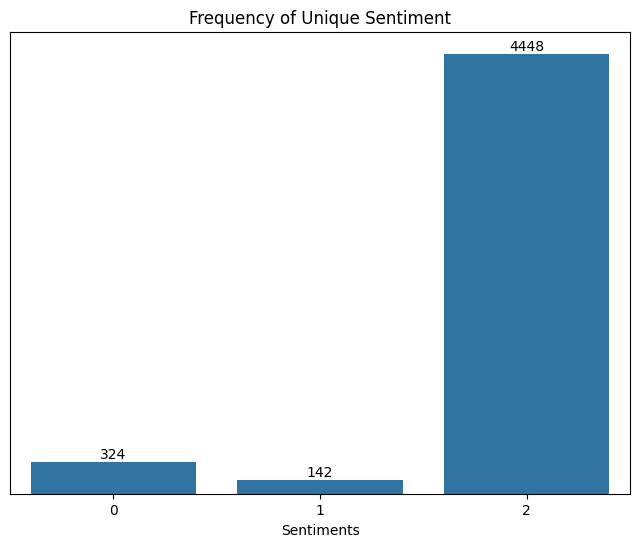

In [15]:
# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

# Agregar etiquetas con la frecuencia en cada barra
for index, value in enumerate(sentiment_counts.values):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

# Configurar el gráfico
plt.xlabel('Sentiments')
plt.ylabel('')  # Dejar el eje Y vacío para que no se muestre la etiqueta
plt.title('Frequency of Unique Sentiment')
plt.gca().axes.yaxis.set_visible(False)  # Ocultar el eje Y
plt.show()

In [16]:
# identificación de la clase Mayoritaria y Minoritaria de la variable de salida 'Sentiment'
majority_class = data[data['sentiment'] == 2]
print(f"Número de muestras en la clase mayoritaria: {len(majority_class)}")
minority_class_1 = data[data['sentiment'] == 1]
print(f"Número de muestras en la clase minoritaria: {len(minority_class_1)}")
minority_class_0 = data[data['sentiment'] == 0]
print(f"Número de muestras en la clase minoritaria: {len(minority_class_0)}")

Número de muestras en la clase mayoritaria: 4448
Número de muestras en la clase minoritaria: 142
Número de muestras en la clase minoritaria: 324


In [17]:
# Sobremuestrear la clase minoritaria_1 (Oversampling)
minority_class_1_upsampled = resample(minority_class_1,
                                    replace=True,    # Hacer muestreo con reemplazo
                                    n_samples=len(majority_class),  # Igualar el número de muestras a la clase mayoritaria
                                    random_state=1)

# Sobremuestrear la clase minoritaria_1 (Oversampling)
minority_class_0_upsampled = resample(minority_class_0,
                                    replace=True,    # Hacer muestreo con reemplazo
                                    n_samples=len(majority_class),  # Igualar el número de muestras a la clase mayoritaria
                                    random_state=1)

In [18]:
# Combinar clases sobremuestreadas
balanced_data = pd.concat([majority_class, minority_class_1_upsampled, minority_class_0_upsampled])

In [19]:
len(balanced_data)

13344

In [20]:
# Mezclar el dataset
balanced_data = balanced_data.sample(frac=1, random_state=1).reset_index(drop=True)
balanced_data.head(5)

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,sentiment
0,1249,Dawn,1.0,Although Amazon claim it is a C10 ultra fast M...,2013-10-12,422,1,0,1,1,1.0,0.206549,0
1,340,"Amazon Customer ""spark_plug_y2k""",5.0,It works good with my phone. Very fast when i...,2012-11-27,741,0,0,0,0,0.0,0.000000,2
2,1009,Code X,5.0,Installed it to my Galaxy S4. Works great!I wa...,2013-02-07,669,0,0,0,0,0.0,0.000000,2
3,3462,Norm D. Plume,1.0,Purchased for my android phone to provide more...,2013-05-31,556,0,0,0,0,0.0,0.000000,0
4,3361,M. Wilson,5.0,I plugged this into my Samsung Galaxy 4 and it...,2014-02-06,305,0,0,0,0,0.0,0.000000,2


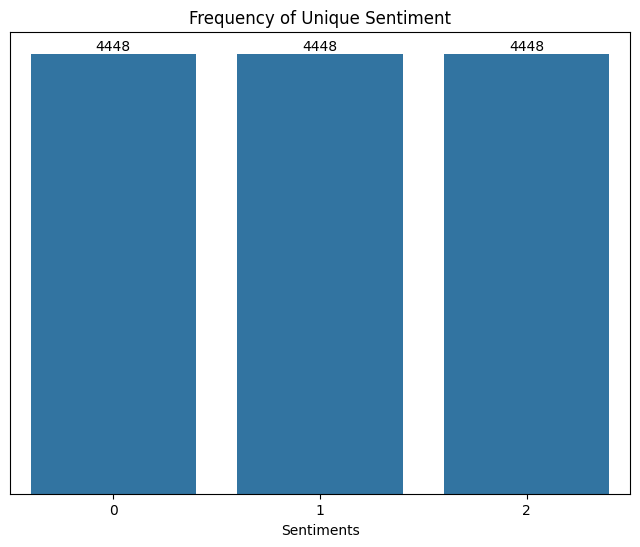

In [21]:
# Contar la frecuencia de cada valor único en la columna 'overall'
sentiment_counts = balanced_data['sentiment'].value_counts().sort_index()
sentiment_counts

# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)

# Agregar etiquetas con la frecuencia en cada barra
for index, value in enumerate(sentiment_counts.values):
    plt.text(index, value + 0.1, str(value), ha='center', va='bottom')

# Configurar el gráfico
plt.xlabel('Sentiments')
plt.ylabel('')  # Dejar el eje Y vacío para que no se muestre la etiqueta
plt.title('Frequency of Unique Sentiment')
plt.gca().axes.yaxis.set_visible(False)  # Ocultar el eje Y
plt.show()

In [22]:
# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [23]:
def preprocess_text(text):
  # Convertir a minúsculas y eliminar puntuación
  text = re.sub(r'[^\w\s]', '', text.lower())

  # Tokenización
  tokens = nltk.word_tokenize(text)

  # Remoción de stopwords
  stop_words = set(stopwords.words('english'))
  tokens = [token for token in tokens if token not in stop_words]

  # Lematización
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens]

  return ' '.join(tokens)

In [24]:
# Preprocesamiento de Texto
balanced_data['preprocessed_text'] = balanced_data['reviewText'].apply(preprocess_text)

In [25]:
# Tokenización del texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(balanced_data['preprocessed_text'])
word_index = tokenizer.word_index

In [26]:
display(word_index)

{'card': 1,
 'phone': 2,
 'sandisk': 3,
 'work': 4,
 'one': 5,
 'problem': 6,
 'sd': 7,
 'memory': 8,
 'would': 9,
 'speed': 10,
 'galaxy': 11,
 'use': 12,
 'get': 13,
 'time': 14,
 'samsung': 15,
 'month': 16,
 'file': 17,
 'bought': 18,
 'great': 19,
 'product': 20,
 'got': 21,
 'class': 22,
 'read': 23,
 'good': 24,
 'even': 25,
 'issue': 26,
 'device': 27,
 'camera': 28,
 'data': 29,
 'format': 30,
 '10': 31,
 'well': 32,
 'video': 33,
 'worked': 34,
 '3': 35,
 'fast': 36,
 'using': 37,
 'like': 38,
 'write': 39,
 'computer': 40,
 'gb': 41,
 '2': 42,
 'tried': 43,
 'adapter': 44,
 'new': 45,
 'used': 46,
 'dont': 47,
 'price': 48,
 'amazon': 49,
 'say': 50,
 'back': 51,
 'still': 52,
 'fine': 53,
 'storage': 54,
 'ive': 55,
 'buy': 56,
 'tablet': 57,
 '64gb': 58,
 '32gb': 59,
 'micro': 60,
 'im': 61,
 'music': 62,
 'microsd': 63,
 'working': 64,
 'need': 65,
 'note': 66,
 'transfer': 67,
 'day': 68,
 'replacement': 69,
 'brand': 70,
 'could': 71,
 'another': 72,
 'never': 73,
 'fir

In [27]:
# Convertir las reseñas a secuencias de enteros
sequences = tokenizer.texts_to_sequences(balanced_data['preprocessed_text'])
print(sequences)

[[519, 49, 375, 1110, 100, 36, 8, 1, 201, 89, 230, 39, 10, 1110, 63, 1, 3763, 940, 801, 10, 779, 268, 190, 3764, 1110, 1319, 63, 1, 136, 356, 254, 3765, 971, 29, 3766, 1090, 63, 1, 905, 1, 116, 1989, 14, 430, 677, 35, 136, 3767, 100, 59, 2366, 3768, 462, 3769, 1110, 1319, 3770, 462, 3771, 10, 209, 1150, 678, 375, 809, 354, 640, 2844, 3772, 678, 27, 25, 3773, 7, 1, 10, 489, 3774, 514, 720, 3775, 421, 3631, 3632, 1, 941, 678, 1], [4, 24, 2, 36, 46, 28, 101, 4, 126, 569, 220], [238, 11, 103, 4, 4177, 156, 1125, 48, 95, 436, 419, 171, 435, 56], [79, 97, 2, 1195, 511, 54, 5, 270, 1990, 1159, 3, 739, 167, 986, 77, 409, 88, 403, 219, 68, 1991, 99, 49, 214, 127, 159, 3165, 197, 49, 259, 1139, 3633, 69, 214, 425, 69, 1286, 4, 74, 494, 534, 2, 537, 17, 175, 942, 1943, 906, 1620, 248, 1352, 99, 293, 3, 203, 409, 159, 122, 208, 81, 14, 3634, 2234, 397, 149, 41, 29, 2184, 1992, 3635, 159, 69, 3, 4, 32, 113, 122, 61, 1525, 89, 1102, 517, 502, 59, 22, 93, 3, 266, 5, 22, 31, 9, 316, 133, 1178, 409, 35

In [28]:
# Rellenar las secuencias para que tengan la misma longitud
max_len = max([len(seq) for seq in sequences])
print(f"El tamaño máximo de las review es de: {max_len}")
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

El tamaño máximo de las review es de: 812


In [29]:
print(padded_sequences)

[[519  49 375 ...   0   0   0]
 [  4  24   2 ...   0   0   0]
 [238  11 103 ...   0   0   0]
 ...
 [  3  98  81 ...   0   0   0]
 [ 21 473 952 ...   0   0   0]
 [ 20   4 235 ...   0   0   0]]


In [37]:
X = padded_sequences
y = to_categorical(balanced_data['sentiment'], num_classes=3)

In [38]:
# Dividir el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Crear el modelo de red neuronal usando Tensorflow
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=128),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Tres salidas para las tres clases
])

In [40]:
# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         1325056   
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 256)         263168    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, None, 256)         0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [42]:
# Definir un callback para detener el entrenamiento si la precisión no mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [43]:
# Entrenar el modelo
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128, callbacks=[early_stopping])

Epoch 1/10
84/84 [==============================] - 263s 3s/step - loss: 0.5173 - accuracy: 0.7680 - val_loss: 0.0607 - val_accuracy: 0.9813
Epoch 2/10
84/84 [==============================] - 254s 3s/step - loss: 0.0489 - accuracy: 0.9890 - val_loss: 0.0689 - val_accuracy: 0.9798
Epoch 3/10
84/84 [==============================] - 253s 3s/step - loss: 0.0226 - accuracy: 0.9952 - val_loss: 0.0237 - val_accuracy: 0.9921
Epoch 4/10
84/84 [==============================] - 255s 3s/step - loss: 0.0220 - accuracy: 0.9952 - val_loss: 0.0418 - val_accuracy: 0.9899
Epoch 5/10
84/84 [==============================] - 254s 3s/step - loss: 0.0086 - accuracy: 0.9983 - val_loss: 0.0508 - val_accuracy: 0.9906
Epoch 6/10
84/84 [==============================] - 254s 3s/step - loss: 0.0025 - accuracy: 0.9998 - val_loss: 0.0349 - val_accuracy: 0.9944


In [44]:
# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {accuracy*100:.2f}%")

84/84 [==============================] - 33s 388ms/step - loss: 0.0349 - accuracy: 0.9944
Precisión en el conjunto de prueba: 99.44%


In [45]:
# Realizar predicciones en todo el conjunto de prueba
predictions = model.predict(X_test)

84/84 [==============================] - 34s 389ms/step


In [46]:
predictions

array([[8.9524565e-07, 2.0963741e-06, 9.9999696e-01],
       [1.9010374e-06, 9.9999255e-01, 5.4463071e-06],
       [9.9970770e-01, 7.3182550e-06, 2.8509347e-04],
       ...,
       [9.9999261e-01, 5.5667306e-07, 6.7835613e-06],
       [3.7849142e-07, 8.5704824e-07, 9.9999881e-01],
       [9.9999750e-01, 1.3482362e-07, 2.4012036e-06]], dtype=float32)

In [47]:
# Utilizar argmax para obtener las categorías predichas
predicted_classes = np.argmax(predictions, axis=1)

In [48]:
# Convertir las secuencias de X_test de vuelta a texto
text_sequences = tokenizer.sequences_to_texts(X_test)

In [49]:
# Obtenemos la confianza de la predicción para la categoría predicha
prediction_confidence = predictions[np.arange(predictions.shape[0]), predicted_classes]

In [50]:
y_test_classes = np.argmax(y_test, axis=1)

In [51]:
# Crear un DataFrame con los resultados
results_df = pd.DataFrame({
    'ReviewText': text_sequences,
    'ExpectedOutput': y_test_classes,
    'PredictedOutput': predicted_classes,
    'PredictionConfidence': prediction_confidence
})

In [52]:
# Mostrar el DataFrame resultante
display(results_df.head())

,ReviewText,ExpectedOutput,PredictedOutput,PredictionConfidence
0,hubby complete happy th go pro havent tested y...,2,2,0.999997
1,find card seems frequently stop working altoge...,1,1,0.999993
2,ordered two none work w cell phone audio playe...,0,0,0.999708
3,title say card got defective faulty issue sd c...,0,0,0.999984
4,forget loading cart one day pause junk went 16...,0,0,0.999992


In [68]:
results_df.loc[1, 'ReviewText']

'find card seems frequently stop working altogether reformatted simply reseated hard know fault device use cellphone card cant really hold say thats experience card others'

In [54]:
# Guardar el DataFrame en un archivo CSV si es necesario
#results_df.to_csv('model_predictions.csv', index=False)

In [55]:
# Guardar el modelo entrenado
joblib.dump(model, 'sentiment_analysis_multiclass_model.pkl')

['sentiment_analysis_multiclass_model.pkl']

In [64]:
# Predicción de sentimiento en una reseña nueva
def predict_sentiment(review):
  # Remover puntuación y convertir a minúsculas
  review_lower = re.sub(r'[^\w\s]', '', review).lower()
  # Limpiar el texto (asumiendo que preprocess_text es una función que ya tienes definida)
  review_cleaned = preprocess_text(review_lower)
  # Convertir el texto a secuencia de tokens
  review_sequence = tokenizer.texts_to_sequences([review_cleaned])
  # Asegurarse de que la secuencia tenga la longitud adecuada
  review_padded = pad_sequences(review_sequence, maxlen=max_len, padding='post')
  # Hacer la predicción
  prediction = model.predict(review_padded)
  # Devolver la categoría de sentimiento basado en la posición del valor ma´ximo de la predicción
  if np.argmax(prediction) == 0:
    return 'Negativo'
  elif np.argmax(prediction) == 1:
    return 'Neutral'
  else:
    return 'Positivo'

In [65]:
# Ejemplo de predicción de reseña positiva
review = "I recently bought the XYZ Bluetooth Speaker, and I couldn't be happier with my purchase! The sound quality is amazing for such a compact device, and the battery life lasts all day. The connection is stable, and it pairs quickly with my phone. Highly recommend it for anyone looking for a portable and reliable speaker."
print(f"Sentimiento de la reseña: {predict_sentiment(review)}")

1/1 [==============================] - 0s 133ms/step
Sentimiento de la reseña: Positivo


In [69]:
# Ejemplo de predicción neutral
review = "find card seems frequently stop working altogether reformatted simply reseated hard know fault device use cellphone card cant really hold say thats experience card others"
print(f"Sentimiento de la reseña: {predict_sentiment(review)}")

1/1 [==============================] - 0s 129ms/step
Sentimiento de la reseña: Neutral


In [67]:
# Ejemplo de predicción negativa
review = "I bought the MNO Smartphone, and it's been a frustrating experience from the start. The battery drains incredibly fast, barely lasting half a day even with minimal use. The camera quality is terrible, producing grainy and washed-out photos. The phone constantly freezes and crashes, making basic tasks like texting or browsing a nightmare. I've also noticed that the touchscreen is unresponsive at times. Overall, this phone is not worth the money, and I regret purchasing it."
print(f"Sentimiento de la reseña: {predict_sentiment(review)}")

1/1 [==============================] - 0s 124ms/step
Sentimiento de la reseña: Negativo
